In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display

from roi_queue import ROIQueue
from stat_helper import *

random_seed = 102
tf.set_random_seed(random_seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def fc_b(x, w, b, drop_out, is_out=False):

    # Fully connected layer
    net = tf.reshape(x, [-1, w.get_shape().as_list()[0]])
    net = tf.add(tf.matmul(net, w), b)
    if not is_out:
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, drop_out)
    return net

def run_graph(dataset_filename,
        layer_params,
        angles=None,
        iterations=8000000,
        batch_size=32,
        drop_out=0.5,
        reg_power=5e-4,
        learning_rate=1e-5):
    
    training_iters = iterations
    if angles is None:
        angles = {
            'train': None,
            'validate': None,
            'test': None
        }
    roi_queue = ROIQueue(
        dataset_filename, 
        batch_size=batch_size, 
        train_angles=angles['train'],
        validate_angles=angles['validate'],
        test_angles=angles['test']
    )
    roi_queue.start()
    
    stat_train_acc = []
    stat_test_acc = []
    stat_data_loss = []
    stat_learning_rate = []
    
    sm_stat_train_acc = []
    sm_stat_test_acc = []
    sm_stat_data_loss = []
    
    X_train, Y_train = roi_queue.get_next_batch('train', 1)
    
    tf.reset_default_graph()
    
    num_features = X_train.shape[1]
    num_classes = Y_train.shape[1]
    
    # Assume random accurecy is 1/n_class +/- 10%
    rand_acc_range = [
        int(100 * (1/num_classes) - (1/num_classes * 10)), 
        int(100 * (1/num_classes) + (1/num_classes * 10))
    ]
    
    sess = tf.Session()



    # tf Graph input
    x = tf.placeholder(tf.float32, [None, num_features], name="x")
    y = tf.placeholder(tf.float32, [None, num_classes], name="y")

    net = x

    previous_layer_size = num_features
    reg = 0
    for idx, current_layer_size in enumerate(layer_params):
        w_id = "W_" + str(idx)
        w = tf.get_variable(w_id, shape=(previous_layer_size, current_layer_size), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.random_normal([current_layer_size]))
        net = fc_b(net, w, b, drop_out)
        previous_layer_size = current_layer_size
        reg += tf.nn.l2_loss(w) + tf.nn.l2_loss(b)

    w_id = "W_" + str(len(layer_params))
    w = tf.get_variable(w_id, shape=(previous_layer_size, num_classes), initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.random_normal([num_classes]))
    reg += tf.nn.l2_loss(w) + tf.nn.l2_loss(b)
    pred = fc_b(net, w, b, 1, is_out=True)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    cost += reg_power * reg
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.scalar_summary('accuracy', accuracy)

    # Initializing the variables
    merged = tf.merge_all_summaries()

    init = tf.initialize_all_variables()
    sess.run(init)
  
    stat_step = 20
    display_step = 2000
    train_loss = 0
    step = 1
    try:
        with sess:


            # Keyep training until reach max iterations
            while step * batch_size < training_iters:
                batch_x, batch_y = roi_queue.get_next_batch('train', batch_size, flattened=True)
                train_dict = {
                    x: batch_x,
                    y: batch_y
                }
                
                # Run optimization op (backprop)
                summary, _ = sess.run([merged, optimizer], feed_dict=train_dict)
                
                if step % stat_step == 0:
                    
                    test_batch_x, test_batch_y = roi_queue.get_next_batch('test', 32, flattened=True)
                    test_dict = {
                        x: test_batch_x,
                        y: test_batch_y
                    }
                        
                    train_acc, train_loss = sess.run([accuracy, cost], feed_dict=train_dict)
                    summary, test_acc = sess.run([merged, accuracy], feed_dict=test_dict)
                    stat_data_loss.append([step * batch_size, train_loss])
                    stat_train_acc.append([step * batch_size, train_acc])
                    stat_test_acc.append([step * batch_size, test_acc])
                    stat_learning_rate.append([step * batch_size, learning_rate])
                    
                
                if step % display_step == 0:
                    
                    steps_count = int(display_step / stat_step)
                    tr_acc = int(get_mean(stat_train_acc, steps=steps_count) * 100)
                    ts_acc = int(get_mean(stat_test_acc, steps=steps_count) * 100)
                    sm_stat_train_acc.append([step * batch_size, tr_acc])
                    sm_stat_test_acc.append([step * batch_size, ts_acc])
                    
                    progress = get_mean_diff(stat_train_acc, steps_count)
                    
                    if progress is not None:
                        if tr_acc < rand_acc_range[1]:
                            if progress is not None and progress < 10:
                                #lr_value = 1e-3
                                pass
                        else:
                            if progress is not None and progress < 5:
                                # lr_value = 1e-7
                                pass


                    update_graph(stat_data_loss, sm_stat_train_acc, sm_stat_test_acc, stat_learning_rate)

                    prg = 0 if progress is None else progress
                    print("Iter " + str(step * batch_size) +
                          ", Loss = {:.6f}".format(train_loss) +
                          ", Training Accuracy = {:.3f}".format(tr_acc) +
                          ", Test Accuracy = {:.3f}".format(ts_acc)
                      )

                step += 1
            
            roi_queue.stop()
            print("Optimization Finished!")
    except KeyboardInterrupt:
            roi_queue.stop()
            print("Optimization Terminated!")

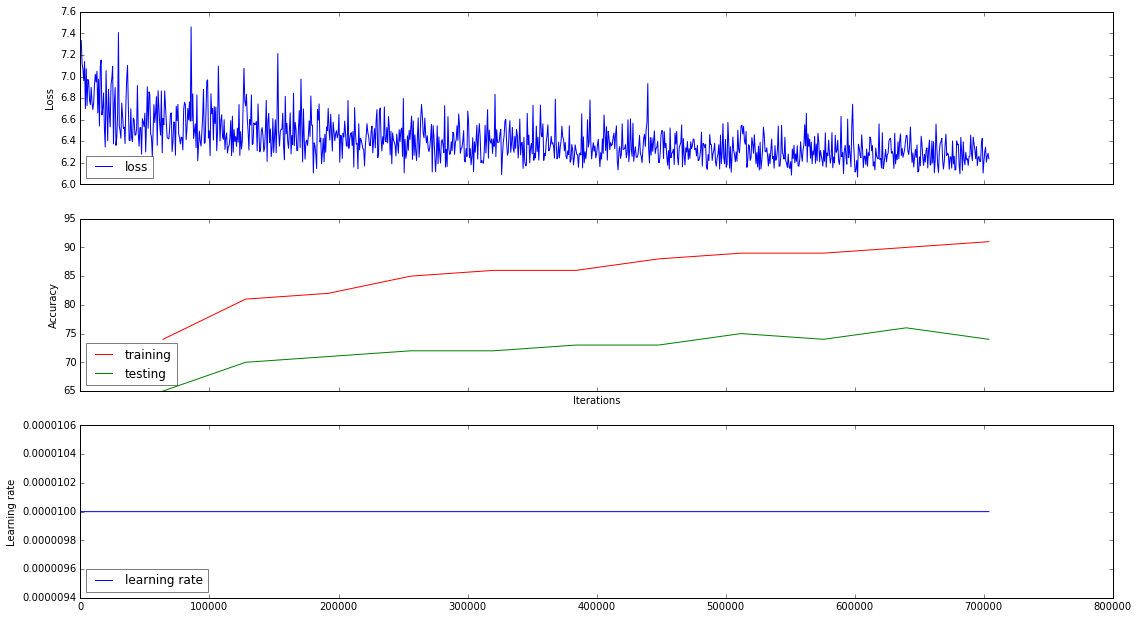

Iter 704000, Loss = 6.235931, Training Accuracy = 91.000, Test Accuracy = 74.000
Optimization Terminated!


In [6]:
run_graph('exported_rois.p', [16384], learning_rate=1e-5, batch_size=32)

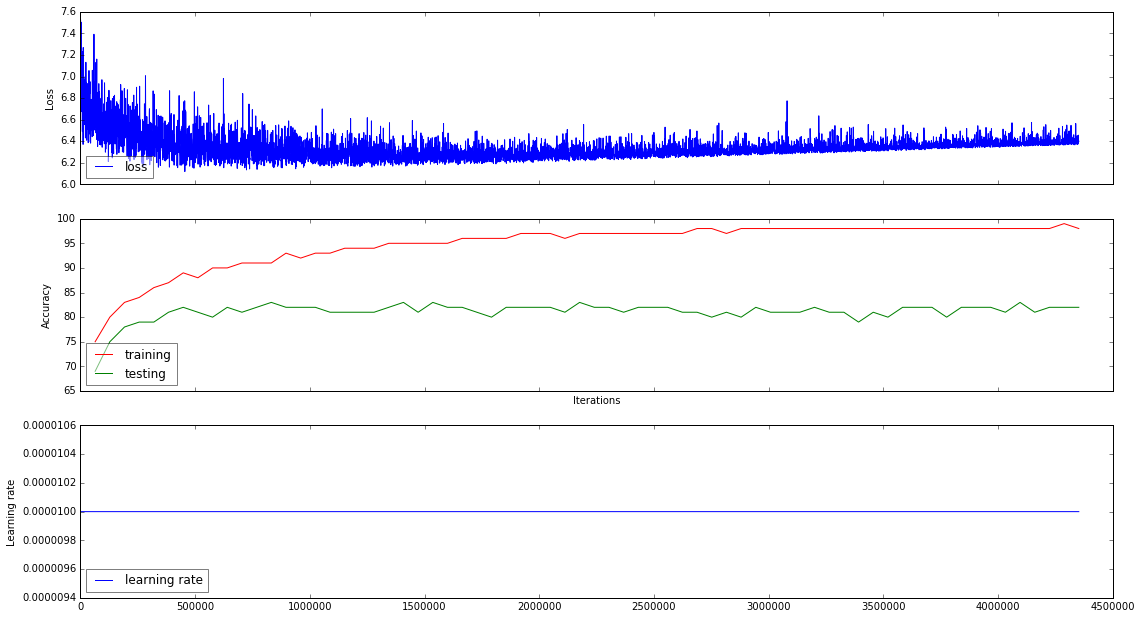

Iter 4352000, Loss = 6.399409, Training Accuracy = 98.000, Test Accuracy = 82.000
Optimization Terminated!


In [11]:
run_graph('exported_rois.p', [16384], learning_rate=1e-5, batch_size=32, iterations=1e7)

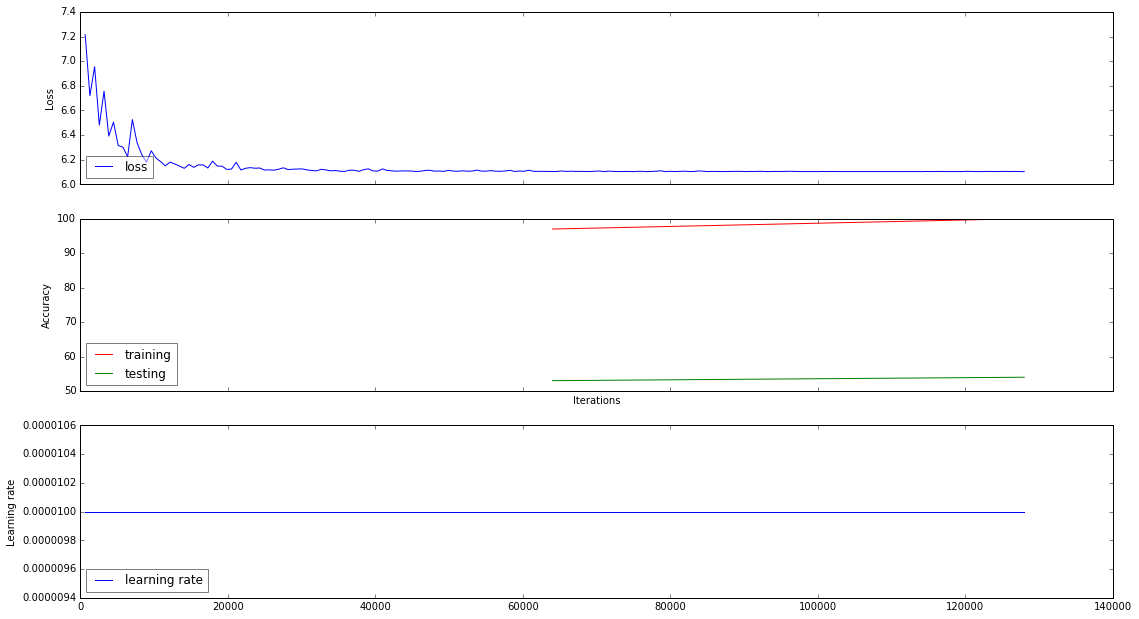

Iter 128000, Loss = 6.102554, Training Accuracy = 100.000, Test Accuracy = 54.000
Optimization Terminated!


In [13]:
run_graph(
    'exported_rois.p', 
    [16384], 
    learning_rate=1e-5, 
    batch_size=32, 
    iterations=1e7,
    angles = {
        'train': list(range(0, 360, 360)),
        'validate': list(range(0, 360, 360)),
        'test': list(range(0, 360, 360))
    }
)